## Introduction

In this blog post I will implement a machine learning model that predicts whether an individual's income is over 50k on the basis of demographics excluding sex. I will also audit for gender bias

## Imports

In [1]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np
import seaborn as sns

## Building Data

For this model we will be looking at PUMS data for the state of New Jersey. We also need to change the PINCP column values. Currently, the values represent the total income of the individual. Now we need it to represent 0 if the individual's income was atleast $50,000 and 0 if it was less.

In [2]:
STATE = "NJ"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)
acs_data.loc[acs_data.PINCP <=50000,"PINCP"]=0
acs_data.loc[acs_data.PINCP >50000,"PINCP"]=1

# acs_data.head()

This data set includes many features/ columns so we will be narrowing them down to a smaller subset of feeatures to consider

In [3]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX',"PINCP", 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,PINCP,RAC1P,ESR
0,23,21.0,5,17,2,NaN,5,2.0,4.0,1,2,2,2,2.0,1,0.0,6,6.0
1,51,20.0,4,17,2,NaN,4,1.0,4.0,1,2,2,2,2.0,1,0.0,1,1.0
2,69,19.0,3,16,1,NaN,1,1.0,4.0,4,1,2,2,2.0,1,0.0,1,6.0
3,18,16.0,5,16,1,NaN,1,1.0,4.0,2,1,2,2,1.0,2,0.0,9,6.0
4,89,19.0,2,16,1,NaN,1,1.0,4.0,4,1,2,2,1.0,2,0.0,1,6.0


subsetting the features:

In [4]:
features_to_use = [f for f in possible_features if f not in ["PINCP", "SEX"]]

Now we construct a basic problem to express our wish to use these features to predict if income (PINCP) >=$50,000 , using the race RAC1P as the group label

In [5]:
IncomeProblem = BasicProblem(
    features=features_to_use,
    target='PINCP',
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = IncomeProblem.df_to_numpy(acs_data)

The result is a features matrix, a label vector and a group label vector

In [6]:
for obj in [features, label, group]:
  print(obj.shape)

(88586, 16)
(88586,)
(88586,)


We should perform a train-test split to split our data into training and testing subsets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

## Basic Descriptives

In [8]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train
df

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,RAC1P,ESR,group,label
0,31.0,14.0,5.0,0.0,2.0,0.0,2.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2,False
1,40.0,21.0,1.0,1.0,2.0,0.0,5.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,6.0,6.0,2,False
2,40.0,22.0,1.0,0.0,2.0,0.0,5.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,6.0,1.0,1,True
3,34.0,21.0,1.0,1.0,2.0,0.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2,True
4,75.0,20.0,5.0,0.0,1.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,6.0,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70863,66.0,21.0,4.0,0.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2,False
70864,32.0,16.0,5.0,2.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1,False
70865,54.0,22.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1,True
70866,42.0,19.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1,False


There are 70868 individuals in the data. Now lets look at what proportion have the target label equal to 1

In [9]:
(df["label"]==1).mean()

0.29835750973641134

31.2% of the data has a target label of 1 meaning 31.2% of the individuals had a total income of at least $50,000. Now, let's check how many people are in each of the groups. The distribution is as follows:

In [10]:
df["group"].value_counts()

2    36491
1    34377
Name: group, dtype: int64

Now we will look at what proportion of individuals have the target label equal to 1. The distribution values are below

In [11]:
df.groupby(["group"])["label"].mean()

group
1    0.363237
2    0.237237
Name: label, dtype: float64

Now we will look at intersectional trends 

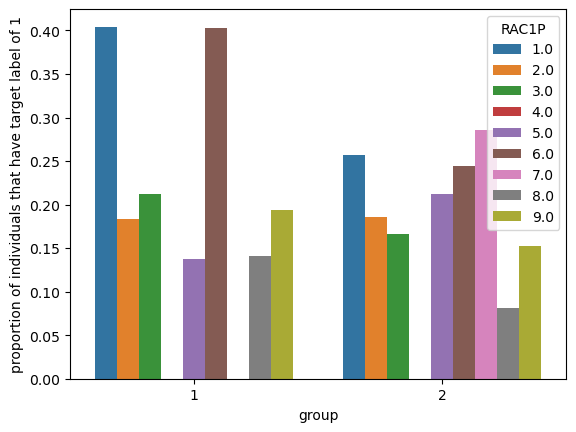

In [12]:
means = df.groupby(["group","RAC1P"])["label"].mean().reset_index(name = "proportion of individuals that have target label of 1")
p = sns.barplot(data = means, x = "group", y = "proportion of individuals that have target label of 1", hue = "RAC1P")

| Group | RAC1P |
| --- | --- |
| 1: male | 1: White alone |
| 2: female | 2: Black or African American alone |
| | 3: American Indian alone |
| | 4: Alaska Native alone |
| | 5: American Indian, Alaska Native alone|
| | 6: Asian alone | 
| | 7: Native Hawaiian and Other Pacific Islander alone |
| | 8: Some other race alone |
| | 9: Two or More Races |

We are looking to see the breakdown of individuals who have a target label of 1 (meaning they have an income >=$50,000) given their race and gender. We can use the mean as our metric because our target label is binary. So, the mean is the proportion of labels with the value 1. It seems like white and asians are the groups with the highest proportion of individuals that have a target label of 1 within both genders

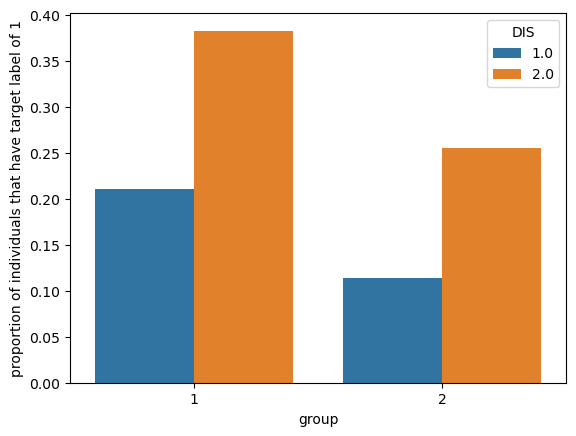

In [13]:
means = df.groupby(["group","DIS"])["label"].mean().reset_index(name = "proportion of individuals that have target label of 1")
p = sns.barplot(data = means, x = "group", y = "proportion of individuals that have target label of 1", hue = "DIS")

For the both groups, there is a correlation between an income over $50,000 and disability status

## Training a model

We will build our model using a decision tree approach. Let's use cross validation to determine the best depth.

In [14]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

best_score = -np.inf
best_depth = 0

for depth in range(2,10):
    pipeline = make_pipeline(StandardScaler(),DecisionTreeClassifier(max_depth = depth))
    scores = cross_val_score(pipeline,X_train,y_train,cv = 6)
    if scores.mean()>best_score:
            best_score = scores.mean()
            best_depth = depth
print(best_depth,best_score)
    


8 0.8248292705055139


Now, let's build our final model

In [15]:
model = make_pipeline(StandardScaler(),DecisionTreeClassifier(max_depth=8))
model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8))])

Now we can generate predictions:

In [16]:
y_hat = model.predict(X_test)

---

### Overall Metrics

The overall accuracy of the model represents the percentage of times that it will correctly predict the target label. So, we are comparing the correct labels to the target labels and taking the mean. Because our label is binary we can take the mean of our equivalence array as the number of times 1 appear (signifying the labels match) is the mean

In [17]:
print("The overall accuracy of this model is: " + str((y_hat==y_test).mean().round(4)))

The overall accuracy of this model is: 0.8219


To find the PPV of our model we first need to calculate the number of true positives and false positives. To do so, we compare the predicted labels to the test labels. If the predicted label is 1 and the acutal label is 1, then that is a true positive. If the predicted label is 1 and the true label is 0 that is a false positive.

In [18]:
TP = len((np.where((y_hat==1) & (y_test==1))[0]))
FP = len((np.where((y_hat==1) & (y_test==0))[0]))
PPV = round((TP)/(TP+FP),4)
print("The positive predictive value of this model is: " + str(PPV))

The positive predictive value of this model is: 0.709


The FPR represents the rate at which a test label of 0 is incorrectly predicted to be 1.
THE FNR represents the rate at which a test label of 1 is incorrectly predicted to be 0.

In [19]:
conf_matrix = confusion_matrix(y_test,y_hat, normalize = 'true')
print("FPR = " + str(conf_matrix[0][1]))
print("FNR = " + str(conf_matrix[1][0])) 

FPR = 0.11853101896496303
FNR = 0.3187334091770952


---

## By Group Measures

Now we will compare the accuracy of our model for individual groups. So we filter by gender

In [24]:
print("The accuracy for male individuals is " + str((y_hat==y_test)[group_test==1].mean().round(4)))
print("The accuracy for female individuals is " + str((y_hat==y_test)[group_test==2].mean().round(4)))


The accuracy for male individuals is 0.8181
The accuracy for female individuals is 0.8255


 Now we will copmare some of the accuracy metrics such as the false positive rate and the false negative rate. They are about equal for both genders which is generally a good sign

In [38]:
conf_matrix_male_norm = confusion_matrix(y_test[group_test==1],y_hat[group_test==1], normalize = 'true')
print("FPR for male individuals = " + str(conf_matrix_male_norm[0][1]))
print("FNR for male individuals = " + str(conf_matrix_male_norm[1][0])) 

conf_matrix_female_norm = confusion_matrix(y_test[group_test==2],y_hat[group_test==2], normalize = 'true')
print("FPR for female individuals = " + str(conf_matrix_female_norm[0][1]))
print("FNR for female individuals = " + str(conf_matrix_female_norm[1][0])) 


FPR for male individuals = 0.1007483117357182
FNR for male individuals = 0.32504038772213245
FPR for female individuals = 0.1323761665470208
FNR for female individuals = 0.3088572739788894


---

## Bias Measures

**Calibration** means that the fraction of predicted people to have an income >= $\$$50,000 who actually had an income >=$50,000 is the same across all groups. So we will calculate this metric for both genders. This metric can be calculated by dividing the number of true positives by the total number of predicted positives.

In [59]:
conf_matrix_male = confusion_matrix(y_test[group_test==1],y_hat[group_test==1])
male_calibration = confusion_matrix(y_test[group_test==1],y_hat[group_test==1])[0][0]/(confusion_matrix(y_test[group_test==1],y_hat[group_test==1])[0].sum())
conf_matrix_female = confusion_matrix(y_test[group_test==2],y_hat[group_test==2])
female_calibration = confusion_matrix(y_test[group_test==2],y_hat[group_test==2])[0][0]/(confusion_matrix(y_test[group_test==2],y_hat[group_test==2])[0].sum())

print("The fraction of males predicted to have an income >=$50000 who actually had an income of >=$50000 is " + str(male_calibration.round(4)))
print("The fraction offe males predicted to have an income >=$50000 who actually had an income of >=$50000 is " + str(female_calibration.round(4)))



The fraction of males predicted to have an income >=$50000 who actually had an income of >=$50000 is 0.8993
The fraction offe males predicted to have an income >=$50000 who actually had an income of >=$50000 is 0.8676


I would say that the model is calibrated as the proportions for each group are roughly the same.

A model satisfies **error rate balance** if the false positive and false negative rates are equal across groups. Looking at the previously calculated FPR anf FNR, I would say that this model satidfies error rate balance. The FPR for both groups is rounghly 12% and the FNR for both groups is roughly 31%.

A model satisifes **statistical parity** if the proportion of individuals classified as having an income >=$50000 is the same for each group. So we compare the total number of predicted positives.

In [58]:
print("The proportion of males classified as having an income greater than $50,000 is " + str((confusion_matrix(y_test[group_test==1],y_hat[group_test==1])[0].sum())/34377))
print("The proportion of females classified as having an income greater than $50,000 is " + str((confusion_matrix(y_test[group_test==2],y_hat[group_test==2])[0].sum())/36491))


The proportion of males classified as having an income greater than $50,000 is 0.1593798179015039
The proportion of females classified as having an income greater than $50,000 is 0.19086898139267217


Again, these values are roughly the same, so I would say that this model satisfies statistical parity.

1. Companies like banks or credit card companies could benefit from this model. Banks often give out loans and need to asses how much money is a safe amount to give to their clients. Knowing their clients' incomes would be very helpful in assesing the risks of pursuing a loan. Credit card companies follow a similar process when determining to accept a clients' credit card request.

2. I think it is interesting that this model gives companies/organizations that don't usually have access to your income more insight into your financials. Job employers usually don't have access to your current salary/wage, but now this algorithm will give them more insight and could potentially help them in deciding a new salary offer. Places like country clubs, whos reputation is encompassed by wealth, could use this kind of algorithm. 

3. Based on my bias audit, I don't think that my model displays problematic bias. The model satisifies the calibration, error rate and statistical parity tests. So, there is no obvious bias, but as always more investigating is also helpful.

4. In my opion the accuracy of this model is not high enoughly to be deployed. The accuracy of the model is about 80% meaning it predicts the wrong out come 20% of the time. To put this into perspective, this model is incorrect for every 5th person. To help remedy this, I would suggest either collecting more data or reevaluating the parameters/factors involved

